# Table of contents
*  [Introduction](#section1) 
*  [Libraries](#section2) 
*  [EDA](#section4)
      - [Read the data in](#section5)
          - [Description](#section6)
          - [Target column](#section7)
      - [Cleaning](#section8)
          - [Missing values](#section9)
              - [Train/Test](#section10)
              - [Merchants](#section11)
              - [Historical transactions](#section12)
              - [New transactions](#section13)
      - [Feature engineering](#section14)
          - [Train/Test](#section15)
          - [Merchants](#section16)
              - [Categorical columns](#section17) 
          - [Historical + New transactions](#section18)
          - [Merge historical and new transactions with merchant info](#section19)
          - [Aggregate function](#section40)   
* [Data preparation](#section20)     
* [Modeling and testing](#section21)
    - [LightGBM](#section22)
    - [Xgboost](#section23)
    - [Summary of results](#section24)
    - [Feature importance](#section25)
    - [Ensembled model: averaged and stacked](#section26)
        - [Model definition](#section27)
        - [Predictions](#section28)
        - [Results](#section29)
* [Submission](#section30)
* [References, thank you!](#section31)

by @samaxtech

If you found this kernel helpful or would like to share your thoughts feel free to upvote and leave a comment! :)

---
<a id='section1'></a>
# Introduction
As part of the Elo Merchant Category Recommendation Kaggle competition, this kernel aims to predict a merchant loyalty score for a certain credict card holder.

<a id='section2'></a>
# Import libraries

In [1]:
import pandas as pd
import numpy as np
import math
import datetime

import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso
from lightgbm.sklearn import LGBMRegressor
from xgboost.sklearn import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from mlxtend.regressor import StackingCVRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep')

/Users/sama/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


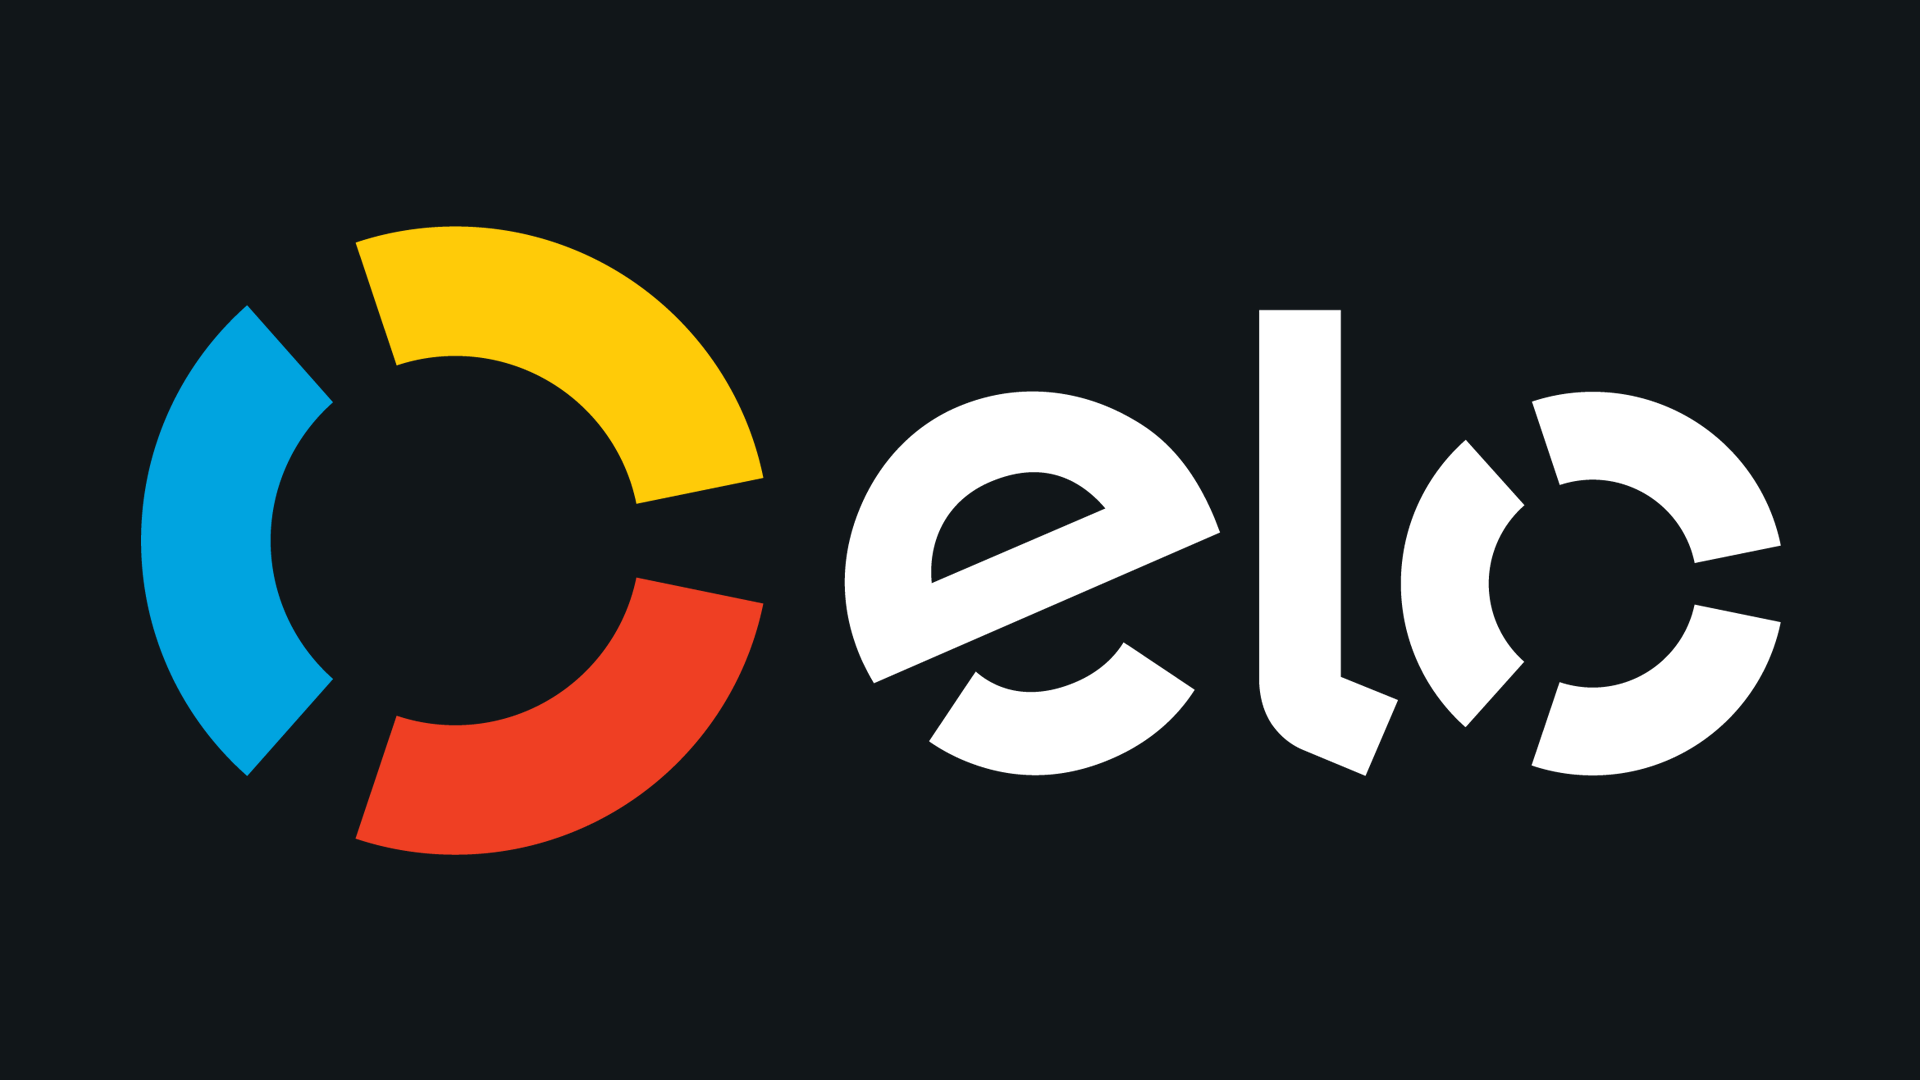

In [2]:
Image(filename='elo_logo.png')

---
<a id='section4'></a>
# EDA 

<a id='section5'></a>
## Read in the data

In [3]:
# Merchants, historical and new transactions data
merchants = pd.read_csv('../input/merchants.csv')
hist_trans = pd.read_csv('../input/historical_transactions.csv')
new_trans = pd.read_csv('../input/new_merchant_transactions.csv')

# Train and Test data
train = pd.read_csv('../input/train.csv', parse_dates=['first_active_month'])
test = pd.read_csv('../input/test.csv', parse_dates=['first_active_month'])

print("--------------------------")
print("Train shape: ", train.shape)
print("Test shape: ", test.shape)
print("--------------------------")
print("Merchants shape: ", merchants.shape)
print("Historical transactions shape: ", hist_trans.shape)
print("New transactions shape: ", new_trans.shape)

--------------------------
Train shape:  (201917, 6)
Test shape:  (123623, 5)
--------------------------
Merchants shape:  (334696, 22)
Historical transactions shape:  (29112361, 14)
New transactions shape:  (1963031, 14)


<a id='section6'></a>
### Description

In [4]:
print("----------------------------------------------------------------")
print("Train")
print("----------------------------------------------------------------")
print(train.info())
print("\n----------------------------------------------------------------")
print("Test")
print("----------------------------------------------------------------")
print(train.info())
print("\n----------------------------------------------------------------")
print("Merchants")
print("----------------------------------------------------------------")
print(merchants.info())
print("\n----------------------------------------------------------------")
print("Historical transactions")
print("----------------------------------------------------------------")
print(hist_trans.info())
print("\n----------------------------------------------------------------")
print("New transactions")
print("----------------------------------------------------------------")
print(new_trans.info())

----------------------------------------------------------------
Train
----------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
first_active_month    201917 non-null datetime64[ns]
card_id               201917 non-null object
feature_1             201917 non-null int64
feature_2             201917 non-null int64
feature_3             201917 non-null int64
target                201917 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 9.2+ MB
None

----------------------------------------------------------------
Test
----------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
first_active_month    201917 non-null datetime64[ns]
card_id               201917 non-null object
feature_1             201917 non-null int64
feat

In [5]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [6]:
test.head()

,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04-01,C_ID_0ab67a22ab,3,3,1
1,2017-01-01,C_ID_130fd0cbdd,2,3,0
2,2017-08-01,C_ID_b709037bc5,5,1,1
3,2017-12-01,C_ID_d27d835a9f,2,1,0
4,2015-12-01,C_ID_2b5e3df5c2,5,1,1


In [7]:
merchants.head()

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,...,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,...,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,...,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


In [8]:
hist_trans.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [9]:
new_trans.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


<a id='section7'></a>
### Target column

In [10]:
print("Target description:\n\n", train['target'].describe())
print("\n--------------------------------------------------------------------------------------------")
print("\nTarget values:\n\n", train['target'].value_counts())

Target description:

 count    201917.000000
mean         -0.393636
std           3.850500
min         -33.219281
25%          -0.883110
50%          -0.023437
75%           0.765453
max          17.965068
Name: target, dtype: float64

--------------------------------------------------------------------------------------------

Target values:

 -33.219281    2207
 0.000000     1630
 1.000000      117
-1.000000       81
-0.584963       35
 0.584963       28
-1.321928       19
 0.284918       17
 1.584963       14
 0.342052       13
-0.415038       12
-1.584963       11
 0.160913       11
-0.321928       11
-0.263034       10
 0.321928       10
 2.000000       10
 1.321928        8
 0.736966        8
-2.000000        8
 0.415038        8
 0.149481        8
-0.736966        7
 0.514573        7
 0.807355        7
-2.321928        7
-3.321928        7
-0.514573        7
 2.321928        6
 0.181140        6
              ... 
-0.201579        1
 0.191210        1
 0.609377        1
 1.4746

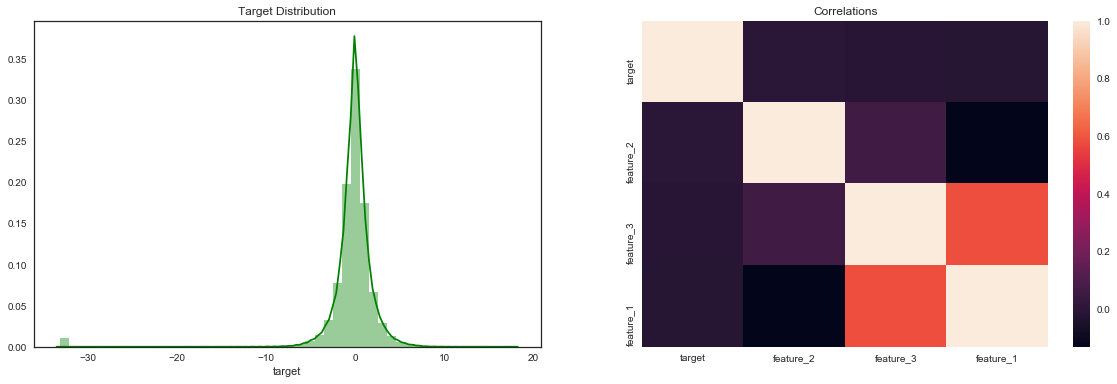

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
ax1, ax2 = axes.flatten()

# Distribution
sns.distplot(train['target'], ax=ax1, color='Green')

# Sorted correlations with target
sorted_corrs = train.corr()['target'].sort_values(ascending=False)
sns.heatmap(train[sorted_corrs.index].corr(), ax=ax2)

ax1.set_title('Target Distribution')
ax2.set_title('Correlations')
plt.show()

There seem to be 2207 values around -33 for the target column, which follows a normal distribution. Let's take that into account. Also, 'feature_3' correlates better than 'feature_2' and 'feature_1' with 'target'.

Let's confirm the number of values under -30.

In [12]:
under_30 = train.loc[train['target'] < -30, 'target'].count()
print("Under -30:", under_30, "values.")

Under -30: 2207 values.


<a id='section8'></a>
# Cleaning
<a id='section9'></a>
## Missing

In [13]:
print("MISSING VALUES BEFORE CLEANING\n")
print("--------------------------------------------------\nTrain:\n--------------------------------------------------\n", train.isnull().sum())
print("\n--------------------------------------------------\nTest:\n--------------------------------------------------\n", test.isnull().sum())
print("\n--------------------------------------------------\nMerchant:\n--------------------------------------------------\n", merchants.isnull().sum())
print("\n--------------------------------------------------\nHistorical transactions:\n--------------------------------------------------\n", hist_trans.isnull().sum())
print("\n--------------------------------------------------\nNew transactions:\n--------------------------------------------------\n", new_trans.isnull().sum())

MISSING VALUES BEFORE CLEANING

--------------------------------------------------
Train:
--------------------------------------------------
 first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
target                0
dtype: int64

--------------------------------------------------
Test:
--------------------------------------------------
 first_active_month    1
card_id               0
feature_1             0
feature_2             0
feature_3             0
dtype: int64

--------------------------------------------------
Merchant:
--------------------------------------------------
 merchant_id                        0
merchant_group_id                  0
merchant_category_id               0
subsector_id                       0
numerical_1                        0
numerical_2                        0
category_1                         0
most_recent_sales_range            0
most_recent_purchases_range        0
avg_sales_l

<a id='section10'></a>
### Train/Test
There's no null values for train. However, there seem to be one observation with a missing 'first_active_month' in test.

In [14]:
test_missing = test[test.isnull()['first_active_month']]
idx_test_missing = test_missing.index
test_missing

,first_active_month,card_id,feature_1,feature_2,feature_3
11578,NaT,C_ID_c27b4f80f7,5,2,1


We can look for all the observations that match the same 'feature_1', 'feature_2' and 'feature_3' values as that, and replace it with the 'first_active_month' that corresponds to their mode.

In [15]:
same_category = test[(test['feature_1'] == 5) & (test['feature_2'] == 2) & (test['feature_3'] == 1)]
test.loc[idx_test_missing, 'first_active_month'] = same_category['first_active_month'].mode()[0]

test.iloc[11578]

first_active_month    2017-01-01 00:00:00
card_id                   C_ID_c27b4f80f7
feature_1                               5
feature_2                               2
feature_3                               1
Name: 11578, dtype: object

<a id='section11'></a>
### Merchant

There are missing values for 'avg_sales_lag3', 'avg_sales_lag6' and 'category_2', which at most (in the case of 'category_2') represent 3% of the total number of observations in 'merchants' (334696). Let's drop those rows.

In [16]:
merchants.dropna(inplace=True)

<a id='section12'></a>
### Historical transactions

Similarly, in this case let's drop the missing rows for 'category_3' and 'merchant_id' (less than 1% of total).

In [17]:
hist_trans.dropna(subset=['category_3', 'merchant_id'], inplace=True)

For 'category_2', since it has about 10% of missing values, let's replace them with the rounded average value (since values for this column include [1.0, 2.0, 3.0, 4.0, 5.0]), as seen below.

In [18]:
hist_trans['category_2'].describe()

count    2.616970e+07
mean     2.193858e+00
std      1.531956e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      5.000000e+00
Name: category_2, dtype: float64

In [19]:
hist_trans['category_2'].fillna((math.floor(hist_trans['category_2'].mean())), inplace=True)

<a id='section13'></a>
### New transactions
Once more, since there are missing values in 'category_3', 'merchant_id', 'category_2' and they add up to no more than about 5%, let's  drop the corresponding rows.

In [20]:
new_trans.dropna(inplace=True)

Lastly, let's confirm no null values are present after cleaning.

In [21]:
print("MISSING VALUES AFTER CLEANING\n")
print("--------------------------------------------------\nTrain:\n--------------------------------------------------\n", train.isnull().sum())
print("\n--------------------------------------------------\nTest:\n--------------------------------------------------\n", test.isnull().sum())
print("\n--------------------------------------------------\nMerchant:\n--------------------------------------------------\n", merchants.isnull().sum())
print("\n--------------------------------------------------\nHistorical transactions:\n--------------------------------------------------\n", hist_trans.isnull().sum())
print("\n--------------------------------------------------\nNew transactions:\n--------------------------------------------------\n", new_trans.isnull().sum())

MISSING VALUES AFTER CLEANING

--------------------------------------------------
Train:
--------------------------------------------------
 first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
target                0
dtype: int64

--------------------------------------------------
Test:
--------------------------------------------------
 first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
dtype: int64

--------------------------------------------------
Merchant:
--------------------------------------------------
 merchant_id                    0
merchant_group_id              0
merchant_category_id           0
subsector_id                   0
numerical_1                    0
numerical_2                    0
category_1                     0
most_recent_sales_range        0
most_recent_purchases_range    0
avg_sales_lag3                 0
avg_purchases_l

<a id='section14'></a>
# Feature engineering

In [23]:
# Merge train and test for data processing
data = pd.concat([train, test], ignore_index=True)

# Check shapes match
print("Train ({}) + Test ({}) observations: {}".format(train.shape[0], test.shape[0], train.shape[0] + test.shape[0]))
print("Merged shape:", data.shape)

Train (201917) + Test (123623) observations: 325540
Merged shape: (325540, 6)


<a id='section15'></a>
## Train/Test

In [24]:
# Year and month, separately
data['year'] = data['first_active_month'].dt.year
data['month'] = data['first_active_month'].dt.month

# Elapsed time, until the latest date on the dataset
data['elapsed_time'] = (datetime.date(2018, 2, 1) - data['first_active_month'].dt.date).dt.days

# Categorical features: 'feature_1', 'feature_2' and 'feature_3'
cont = 1
for col in ['feature_1', 'feature_2', 'feature_3']:
    dummy_col = pd.get_dummies(data[col], prefix='f{}'.format(cont))
    data = pd.concat([data, dummy_col], axis=1)
    data.drop(col, axis=1, inplace=True)
    cont += 1
    
data.head()

,card_id,first_active_month,target,year,month,elapsed_time,f1_1,f1_2,f1_3,f1_4,f1_5,f2_1,f2_2,f2_3,f3_0,f3_1
0,C_ID_92a2005557,2017-06-01,-0.820283,2017,6,245,0,0,0,0,1,0,1,0,0,1
1,C_ID_3d0044924f,2017-01-01,0.392913,2017,1,396,0,0,0,1,0,1,0,0,1,0
2,C_ID_d639edf6cd,2016-08-01,0.688056,2016,8,549,0,1,0,0,0,0,1,0,1,0
3,C_ID_186d6a6901,2017-09-01,0.142495,2017,9,153,0,0,0,1,0,0,0,1,1,0
4,C_ID_cdbd2c0db2,2017-11-01,-0.159749,2017,11,92,1,0,0,0,0,0,0,1,1,0


---
<a id='section16'></a>
## Merchants

<a id='section17'></a>
### Categorical columns
Let's start by working out the categorical columns.

In [25]:
merchants.select_dtypes(include='object').head()

,merchant_id,category_1,most_recent_sales_range,most_recent_purchases_range,category_4
0,M_ID_838061e48c,N,E,E,N
1,M_ID_9339d880ad,N,E,E,N
2,M_ID_e726bbae1e,N,E,E,N
16,M_ID_c929bb59af,N,E,E,N
17,M_ID_dd3ae3de10,N,E,E,Y


In [26]:
# Check their values
print(merchants['category_1'].value_counts())
print(merchants['most_recent_sales_range'].value_counts())
print(merchants['most_recent_purchases_range'].value_counts())
print(merchants['category_4'].value_counts())

N    322802
Name: category_1, dtype: int64
E    172085
D    112849
C     32224
B      4732
A       912
Name: most_recent_sales_range, dtype: int64
E    168222
D    115430
C     33339
B      4864
A       947
Name: most_recent_purchases_range, dtype: int64
N    233744
Y     89058
Name: category_4, dtype: int64


'category_1' only has one value, i.e. it's not going to be useful for the model. Let's drop that column. Let's create categorical columns for 'most_recent_sales_range' and 'most_recent_purchases_range', and a binary column for 'category_4'.

In [27]:
# Drop 'category_1'
merchants.drop('category_1', axis=1, inplace=True)
print('category_1' in merchants.columns)

# Categorical features: 'most_recent_sales_range' and 'most_recent_purchases_range'
cont = 'recent_sales'
for col in ['most_recent_sales_range', 'most_recent_purchases_range']:
    dummy_col = pd.get_dummies(merchants[col], prefix='{}'.format(cont))
    merchants = pd.concat([merchants, dummy_col], axis=1)
    merchants.drop(col, axis=1, inplace=True)
    cont = 'recent_purchases'

# Change Yes/No for 0/1 in 'category_4'
yes_no_dict = {'Y':1, 'N':0}
merchants['category_4'] = merchants['category_4'].map(yes_no_dict)

False


In [28]:
merchants.head()

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,...,recent_sales_A,recent_sales_B,recent_sales_C,recent_sales_D,recent_sales_E,recent_purchases_A,recent_purchases_B,recent_purchases_C,recent_purchases_D,recent_purchases_E
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,-0.40,9.666667,3,-2.25,...,0,0,0,0,1,0,0,0,0,1
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,-0.72,1.750000,3,-0.74,...,0,0,0,0,1,0,0,0,0,1
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,-82.13,260.000000,2,-82.13,...,0,0,0,0,1,0,0,0,0,1
16,M_ID_c929bb59af,9514,2,20,-0.057471,-0.057471,69667.00,1.000000,3,69667.00,...,0,0,0,0,1,0,0,0,0,1
17,M_ID_dd3ae3de10,30534,278,37,-0.057471,-0.057471,5180.00,4.000000,3,9830.00,...,0,0,0,0,1,0,0,0,0,1


<a id='section18'></a>
### Historical + New transactions
Let's create a column called 'new' on 'hist_trans' and 'new_trans' such that, before concatening them, they have the age reference:

- 1: New
- 0: Historical

In [29]:
new_trans['new'] = 1
hist_trans['new'] = 0

# Concatenate new_trans and hist_trans
trans_data = pd.concat([new_trans, hist_trans])

More preprocessing: 'category_1', 'category_2' and 'category_3'.

In [30]:
# Change Yes/No for 0/1 in 'authorized_flag' and 'category_1'
yes_no_dict = {'Y':1, 'N':0}
trans_data['authorized_flag'] = trans_data['authorized_flag'].map(yes_no_dict)
trans_data['category_1'] = trans_data['category_1'].map(yes_no_dict)

# Create five different cols for 'category_2'
dummy_col = pd.get_dummies(trans_data['category_2'], prefix='category_2')
trans_data = pd.concat([trans_data, dummy_col], axis=1)
trans_data.drop('category_2', axis=1, inplace=True)
    
# Create three different cols for categorical A/B/C in 'category_3'
dummy_col = pd.get_dummies(trans_data['category_3'], prefix='cat3')
trans_data = pd.concat([trans_data, dummy_col], axis=1)
trans_data.drop('category_3', axis=1, inplace=True)

trans_data.head()

,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,...,subsector_id,new,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,cat3_A,cat3_B,cat3_C
0,1,C_ID_415bb3a509,107,0,1,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,...,19,1,1,0,0,0,0,0,1,0
1,1,C_ID_415bb3a509,140,0,1,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,...,19,1,1,0,0,0,0,0,1,0
2,1,C_ID_415bb3a509,330,0,1,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,...,14,1,1,0,0,0,0,0,1,0
5,1,C_ID_ef55cf8d4b,231,0,1,367,M_ID_8874615e00,2,-0.633007,2018-04-02 12:53:28,...,16,1,1,0,0,0,0,0,1,0
6,1,C_ID_ef55cf8d4b,69,0,1,333,M_ID_6d061b5ddc,1,5.263697,2018-03-28 19:50:19,...,10,1,1,0,0,0,0,0,1,0


<a id='section19'></a>
### Merge historical and new transactions with merchant info
I am only going to keep the categorical features from merchants (as well as 'merchant_id' to be able to merge both dataframes).

In [31]:
merge_cols = ['merchant_id', 'recent_sales_A', 'recent_sales_B', 'recent_sales_C', 
              'recent_sales_D', 'recent_sales_E', 'recent_purchases_A', 'recent_purchases_B',
              'recent_purchases_C', 'recent_purchases_D', 'recent_purchases_E', 'category_4']

merchants_merge = merchants[merge_cols]

# Merge
trans_merchants = pd.merge(trans_data, merchants_merge, on='merchant_id', how='left')

In [32]:
# Check dtypes before aggregation 
print(trans_merchants.info())
trans_merchants.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30653006 entries, 0 to 30653005
Data columns (total 32 columns):
authorized_flag         int64
card_id                 object
city_id                 int64
category_1              int64
installments            int64
merchant_category_id    int64
merchant_id             object
month_lag               int64
purchase_amount         float64
purchase_date           object
state_id                int64
subsector_id            int64
new                     int64
category_2_1.0          uint8
category_2_2.0          uint8
category_2_3.0          uint8
category_2_4.0          uint8
category_2_5.0          uint8
cat3_A                  uint8
cat3_B                  uint8
cat3_C                  uint8
recent_sales_A          float64
recent_sales_B          float64
recent_sales_C          float64
recent_sales_D          float64
recent_sales_E          float64
recent_purchases_A      float64
recent_purchases_B      float64
recent_purchases_C      fl

,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,...,recent_sales_B,recent_sales_C,recent_sales_D,recent_sales_E,recent_purchases_A,recent_purchases_B,recent_purchases_C,recent_purchases_D,recent_purchases_E,category_4
0,1,C_ID_415bb3a509,107,0,1,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,C_ID_415bb3a509,140,0,1,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1,C_ID_415bb3a509,330,0,1,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,C_ID_ef55cf8d4b,231,0,1,367,M_ID_8874615e00,2,-0.633007,2018-04-02 12:53:28,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1,C_ID_ef55cf8d4b,69,0,1,333,M_ID_6d061b5ddc,1,5.263697,2018-03-28 19:50:19,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0


---
<a id='section40'></a>
### Aggregate function
Aggregate function, grouped by 'card_id': min, max, mean, median, std, sum, nunique, range. 

Added:
- Count on 'installments' and 'purchase_amount'.
- Mode() on 'new' column (previously created).
- Mean on new trans_data's category_2 dummy columns.
- Mean on trans_data's category_4.
- Mean on 'cat3_A', 'cat3_B' and 'cat3_C' (old 'category_3').
- Mean on merchants' new dummy columns.

In [40]:
def aggregate_historical_transactions(trans_merchants):
    
    trans_merchants.loc[:, 'purchase_date'] = pd.DatetimeIndex(trans_merchants['purchase_date']).astype(np.int64)*1e-9
    
    agg_func = {
        'authorized_flag': ['sum', 'mean'],
        'category_1': ['mean'],
        'category_2_1.0': ['mean'],
        'category_2_2.0': ['mean'],
        'category_2_3.0': ['mean'],
        'category_2_4.0': ['mean'],
        'category_2_5.0': ['mean'],
        'cat3_A': ['mean'],
        'cat3_B': ['mean'],
        'cat3_C': ['mean'],
        'recent_sales_A': ['mean'], 
        'recent_sales_B': ['mean'], 
        'recent_sales_C': ['mean'], 
        'recent_sales_D': ['mean'], 
        'recent_sales_E': ['mean'], 
        'recent_purchases_A': ['mean'], 
        'recent_purchases_B': ['mean'], 
        'recent_purchases_C': ['mean'], 
        'recent_purchases_D': ['mean'], 
        'recent_purchases_E': ['mean'], 
        'category_4': ['mean'], 
        'merchant_id': ['nunique'],
        'merchant_category_id': ['nunique'],
        'state_id': ['nunique'],
        'city_id': ['nunique'],
        'subsector_id': ['nunique'],
        'purchase_amount': ['count', 'sum', 'median', 'max', 'min', 'std'],
        'installments': ['count', 'sum', 'median', 'max', 'min', 'std'],
        'purchase_date': [np.ptp],
        'month_lag': ['min', 'max'],
        'new':[lambda x:x.value_counts().index[0]] # Mode
        }
    
    agg_history = trans_merchants.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)

    df = (trans_merchants.groupby('card_id').size().reset_index(name='transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history

trans_data = aggregate_historical_transactions(trans_merchants)
trans_data.head()

,card_id,transactions_count,authorized_flag_sum,authorized_flag_mean,category_1_mean,category_2_1.0_mean,category_2_2.0_mean,category_2_3.0_mean,category_2_4.0_mean,category_2_5.0_mean,...,installments_count,installments_sum,installments_median,installments_max,installments_min,installments_std,purchase_date_ptp,month_lag_min,month_lag_max,new_<lambda>
0,C_ID_00007093c1,151,116,0.768212,0.185430,0.006623,0.185430,0.801325,0.0,0.006623,...,151,194,1.0,6,1,0.760504,0.036210,-12,2,0
1,C_ID_0001238066,142,139,0.978873,0.014085,0.795775,0.049296,0.000000,0.0,0.154930,...,142,236,1.0,10,1,1.529322,0.018481,-5,2,0
2,C_ID_0001506ef0,67,63,0.940299,0.000000,0.029851,0.000000,0.970149,0.0,0.000000,...,67,1,0.0,1,0,0.122169,0.037300,-13,1,0
3,C_ID_0001793786,245,218,0.889796,0.008163,0.106122,0.808163,0.081633,0.0,0.004082,...,245,5,0.0,1,0,0.141681,0.029748,-9,2,0
4,C_ID_000183fdda,150,143,0.953333,0.026667,0.046667,0.033333,0.913333,0.0,0.006667,...,150,285,1.0,10,1,2.039048,0.022651,-6,2,0


<a id='section20'></a>
# Data preparation

In [41]:
# Merch data (train + test) with trans_data (historical + new transactions) and merchant (merchant info)
processed_data = pd.merge(data, trans_data, on='card_id', how='left')
print(processed_data.shape)
processed_data.head()

(325540, 60)


,card_id,first_active_month,target,year,month,elapsed_time,f1_1,f1_2,f1_3,f1_4,...,installments_count,installments_sum,installments_median,installments_max,installments_min,installments_std,purchase_date_ptp,month_lag_min,month_lag_max,new_<lambda>
0,C_ID_92a2005557,2017-06-01,-0.820283,2017,6,245,0,0,0,0,...,277,4,0.0,1,0,0.119513,0.026428,-8,2,0
1,C_ID_3d0044924f,2017-01-01,0.392913,2017,1,396,0,0,0,1,...,354,551,1.0,10,1,1.491591,0.038672,-12,2,0
2,C_ID_d639edf6cd,2016-08-01,0.688056,2016,8,549,0,1,0,0,...,44,0,0.0,0,0,0.000000,0.040815,-13,2,0
3,C_ID_186d6a6901,2017-09-01,0.142495,2017,9,153,0,0,0,1,...,83,94,1.0,3,1,0.462524,0.017506,-5,2,0
4,C_ID_cdbd2c0db2,2017-11-01,-0.159749,2017,11,92,1,0,0,0,...,166,215,1.0,12,1,1.703003,0.014497,-3,2,0


In [44]:
# Train and Test
train_idx = train.shape[0]
test_idx = test.shape[0]

train = processed_data[:train_idx]
test = processed_data[train_idx:]

cols = ['recent_sales_A_mean','recent_sales_B_mean', 'recent_sales_C_mean','recent_sales_D_mean', 
       'recent_sales_E_mean', 'recent_purchases_A_mean', 'recent_purchases_B_mean', 'recent_purchases_C_mean', 
       'recent_purchases_D_mean', 'recent_purchases_E_mean', 'category_4_mean',
       'purchase_amount_std', 'installments_std']

for col in cols:
    train[col].fillna((train[col].value_counts().index[0]), inplace=True)

target = train['target']

cols_2_remove = ['target', 'card_id', 'first_active_month']
for col in cols_2_remove:  
    del train[col]
    del test[col] 

# Check on shapes
print("--------------------------")
print("Train shape: ", train.shape)
print("Test shape: ", test.shape)
print("--------------------------")

--------------------------
Train shape:  (201917, 57)
Test shape:  (123623, 57)
--------------------------


---
<a id='section21'></a>
# Modeling and testing

<a id='section22'></a>
## LightGBM

In [50]:
lgb_params = {'num_leaves': 50,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1}

FOLDs = KFold(n_splits=5, shuffle=True, random_state=1989)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))

features_lgb = list(train.columns)
feature_importance_df_lgb = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(FOLDs.split(train)):
    trn_data = lgb.Dataset(train.iloc[trn_idx], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx], label=target.iloc[val_idx])

    print("LGB " + str(fold_) + "-" * 50)
    num_round = 2000
    clf = lgb.train(lgb_params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 2000)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx], num_iteration=clf.best_iteration)

    fold_importance_df_lgb = pd.DataFrame()
    fold_importance_df_lgb["feature"] = features_lgb
    fold_importance_df_lgb["importance"] = clf.feature_importance()
    fold_importance_df_lgb["fold"] = fold_ + 1
    feature_importance_df_lgb = pd.concat([feature_importance_df_lgb, fold_importance_df_lgb], axis=0)
    predictions_lgb += clf.predict(test, num_iteration=clf.best_iteration) / FOLDs.n_splits
    

print(np.sqrt(mean_squared_error(oof_lgb, target)))

LGB 0--------------------------------------------------
Training until validation scores don't improve for 2000 rounds.
[200]	training's rmse: 3.68192	valid_1's rmse: 3.83977
[400]	training's rmse: 3.60836	valid_1's rmse: 3.81941
[600]	training's rmse: 3.55762	valid_1's rmse: 3.8128
[800]	training's rmse: 3.51848	valid_1's rmse: 3.80971
[1000]	training's rmse: 3.48816	valid_1's rmse: 3.80853
[1200]	training's rmse: 3.46222	valid_1's rmse: 3.80793
[1400]	training's rmse: 3.43863	valid_1's rmse: 3.80795
[1600]	training's rmse: 3.41786	valid_1's rmse: 3.80759
[1800]	training's rmse: 3.39951	valid_1's rmse: 3.80797
[2000]	training's rmse: 3.38129	valid_1's rmse: 3.80808
Did not meet early stopping. Best iteration is:
[2000]	training's rmse: 3.38129	valid_1's rmse: 3.80808
LGB 1--------------------------------------------------
Training until validation scores don't improve for 2000 rounds.
[200]	training's rmse: 3.71232	valid_1's rmse: 3.71839
[400]	training's rmse: 3.63683	valid_1's rmse:

<a id='section23'></a>
## Xgboost

In [54]:
train.rename(index=str, columns={"new_<lambda>": "new_mode"}, inplace=True)
test.rename(index=str, columns={"new_<lambda>": "new_mode"}, inplace=True)

xgb_params = {'eta': 0.001, 'max_depth': 7, 'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True}

FOLDs = KFold(n_splits=5, shuffle=True, random_state=1989)

oof_xgb = np.zeros(len(train))
predictions_xgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(FOLDs.split(train)):
    trn_data = xgb.DMatrix(data=train.iloc[trn_idx], label=target.iloc[trn_idx])
    val_data = xgb.DMatrix(data=train.iloc[val_idx], label=target.iloc[val_idx])
    watchlist = [(trn_data, 'train'), (val_data, 'valid')]
    print("xgb " + str(fold_) + "-" * 50)
    num_round = 2000
    xgb_model = xgb.train(xgb_params, trn_data, num_round, watchlist, early_stopping_rounds=100, verbose_eval=200)
    oof_xgb[val_idx] = xgb_model.predict(xgb.DMatrix(train.iloc[val_idx]), ntree_limit=xgb_model.best_ntree_limit+50)

    predictions_xgb += xgb_model.predict(xgb.DMatrix(test), ntree_limit=xgb_model.best_ntree_limit+50) / FOLDs.n_splits

np.sqrt(mean_squared_error(oof_xgb, target))

xgb 0--------------------------------------------------
[0]	train-rmse:3.93297	valid-rmse:4.02939
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[200]	train-rmse:3.86147	valid-rmse:3.96834
[400]	train-rmse:3.80789	valid-rmse:3.92525
[600]	train-rmse:3.76689	valid-rmse:3.89428
[800]	train-rmse:3.734	valid-rmse:3.87177
[1000]	train-rmse:3.70784	valid-rmse:3.85608
[1200]	train-rmse:3.68574	valid-rmse:3.84461
[1400]	train-rmse:3.66703	valid-rmse:3.83633
[1600]	train-rmse:3.65105	valid-rmse:3.83019
[1800]	train-rmse:3.63737	valid-rmse:3.82562
[1999]	train-rmse:3.62483	valid-rmse:3.82209
xgb 1--------------------------------------------------
[0]	train-rmse:3.96772	valid-rmse:3.89065
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[200]	train-rmse:3.89317	valid-rmse:3.83144
[400]	train-rmse:3.83693

3.748787845530182

<a id='section24'></a>
## Summary of results

In [59]:
print("-----------------\nScores on train\n-----------------")
print('lgb:', np.sqrt(mean_squared_error(oof_lgb, target)))
print('xgb:', np.sqrt(mean_squared_error(oof_xgb, target)))

total_sum = 0.5*oof_lgb + 0.5*oof_xgb

print("CV score: {:<8.5f}".format(mean_squared_error(total_sum, target)**0.5))

-----------------
Scores on train
-----------------
lgb: 3.73556474384
xgb: 3.74878784553
CV score: 3.73791 


<a id='section25'></a>
## Feature importance

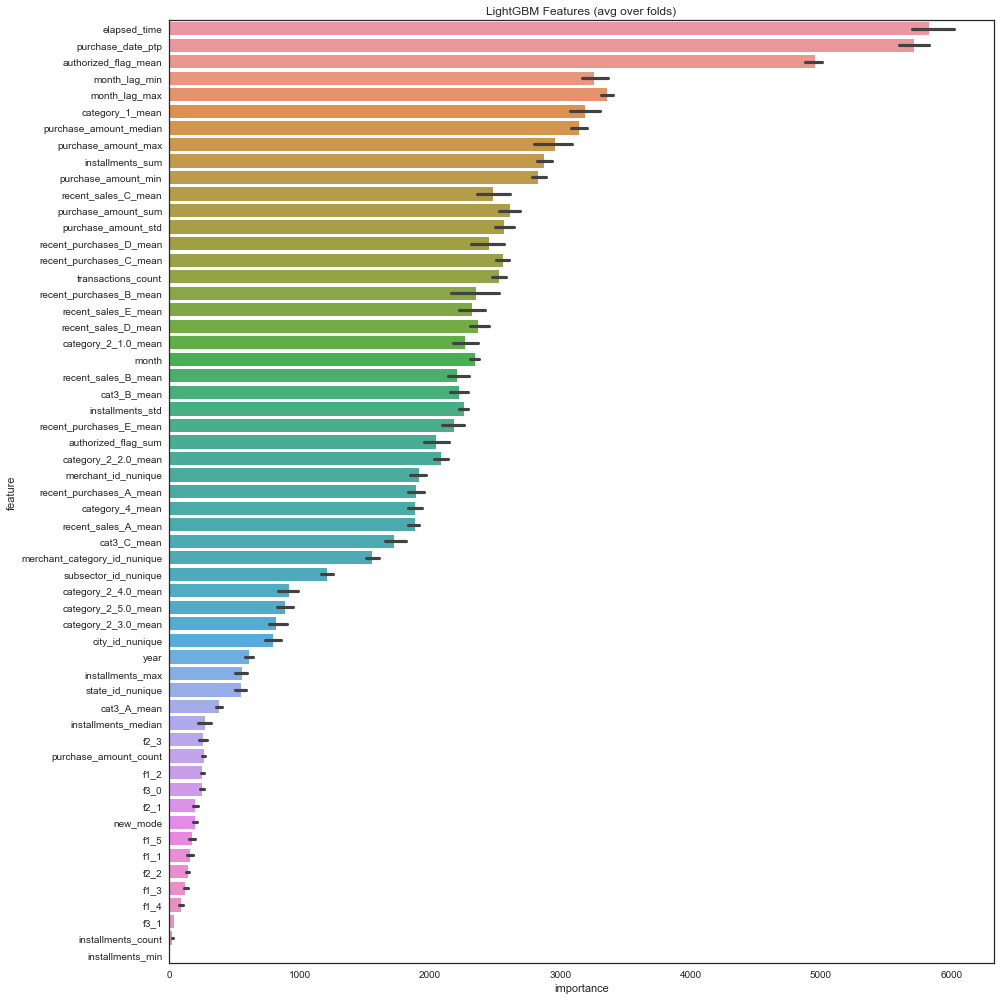

In [60]:
cols = (feature_importance_df_lgb[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df_lgb.loc[feature_importance_df_lgb.feature.isin(cols)]

plt.figure(figsize=(14,14))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

---
<a id='section26'></a>
# Ensembled model: averaged and stacked
The follwing tests lgbm, xgb, catboost, random forest, decision tree, knn, ridge and lasso models individual performance, and compared for averaged and stacked models.
<a id='section27'></a>
## Model definition

0:	learn: 3.8795651	total: 28.4ms	remaining: 4.22s
1:	learn: 3.8750430	total: 51ms	remaining: 3.77s
2:	learn: 3.8704828	total: 74.8ms	remaining: 3.67s
3:	learn: 3.8663858	total: 96.9ms	remaining: 3.54s
4:	learn: 3.8623688	total: 121ms	remaining: 3.51s
5:	learn: 3.8588781	total: 145ms	remaining: 3.47s
6:	learn: 3.8554540	total: 168ms	remaining: 3.42s
7:	learn: 3.8524158	total: 190ms	remaining: 3.38s
8:	learn: 3.8487214	total: 214ms	remaining: 3.35s
9:	learn: 3.8456392	total: 241ms	remaining: 3.37s
10:	learn: 3.8425613	total: 270ms	remaining: 3.41s
11:	learn: 3.8397206	total: 298ms	remaining: 3.43s
12:	learn: 3.8369037	total: 329ms	remaining: 3.46s
13:	learn: 3.8344196	total: 355ms	remaining: 3.45s
14:	learn: 3.8316611	total: 379ms	remaining: 3.41s
15:	learn: 3.8294571	total: 400ms	remaining: 3.35s
16:	learn: 3.8270132	total: 424ms	remaining: 3.32s
17:	learn: 3.8249590	total: 449ms	remaining: 3.29s
18:	learn: 3.8230374	total: 477ms	remaining: 3.29s
19:	learn: 3.8208993	total: 506ms	remai

17:	learn: 3.8031402	total: 451ms	remaining: 3.31s
18:	learn: 3.8010455	total: 478ms	remaining: 3.29s
19:	learn: 3.7992625	total: 503ms	remaining: 3.27s
20:	learn: 3.7973624	total: 526ms	remaining: 3.23s
21:	learn: 3.7956718	total: 552ms	remaining: 3.21s
22:	learn: 3.7940215	total: 574ms	remaining: 3.17s
23:	learn: 3.7924829	total: 597ms	remaining: 3.13s
24:	learn: 3.7910926	total: 619ms	remaining: 3.1s
25:	learn: 3.7892920	total: 645ms	remaining: 3.08s
26:	learn: 3.7881927	total: 671ms	remaining: 3.06s
27:	learn: 3.7870851	total: 699ms	remaining: 3.05s
28:	learn: 3.7857621	total: 725ms	remaining: 3.02s
29:	learn: 3.7845519	total: 746ms	remaining: 2.98s
30:	learn: 3.7839490	total: 766ms	remaining: 2.94s
31:	learn: 3.7824209	total: 792ms	remaining: 2.92s
32:	learn: 3.7808711	total: 817ms	remaining: 2.9s
33:	learn: 3.7795683	total: 839ms	remaining: 2.86s
34:	learn: 3.7786915	total: 861ms	remaining: 2.83s
35:	learn: 3.7773771	total: 890ms	remaining: 2.82s
36:	learn: 3.7760231	total: 914ms

34:	learn: 3.7788740	total: 1.14s	remaining: 3.74s
35:	learn: 3.7776944	total: 1.17s	remaining: 3.7s
36:	learn: 3.7768654	total: 1.24s	remaining: 3.78s
37:	learn: 3.7762676	total: 1.27s	remaining: 3.76s
38:	learn: 3.7754792	total: 1.33s	remaining: 3.78s
39:	learn: 3.7748890	total: 1.37s	remaining: 3.77s
40:	learn: 3.7743340	total: 1.43s	remaining: 3.8s
41:	learn: 3.7738714	total: 1.46s	remaining: 3.74s
42:	learn: 3.7730743	total: 1.49s	remaining: 3.7s
43:	learn: 3.7724854	total: 1.51s	remaining: 3.64s
44:	learn: 3.7714309	total: 1.54s	remaining: 3.59s
45:	learn: 3.7707899	total: 1.56s	remaining: 3.54s
46:	learn: 3.7702583	total: 1.61s	remaining: 3.54s
47:	learn: 3.7695888	total: 1.66s	remaining: 3.52s
48:	learn: 3.7689865	total: 1.69s	remaining: 3.48s
49:	learn: 3.7685903	total: 1.73s	remaining: 3.47s
50:	learn: 3.7676304	total: 1.79s	remaining: 3.48s
51:	learn: 3.7667780	total: 1.84s	remaining: 3.46s
52:	learn: 3.7661645	total: 1.87s	remaining: 3.43s
53:	learn: 3.7656423	total: 1.9s	r

48:	learn: 3.7869529	total: 1.1s	remaining: 2.28s
49:	learn: 3.7861466	total: 1.13s	remaining: 2.27s
50:	learn: 3.7858164	total: 1.15s	remaining: 2.24s
51:	learn: 3.7855713	total: 1.17s	remaining: 2.21s
52:	learn: 3.7852019	total: 1.19s	remaining: 2.18s
53:	learn: 3.7844393	total: 1.21s	remaining: 2.16s
54:	learn: 3.7839682	total: 1.23s	remaining: 2.12s
55:	learn: 3.7832907	total: 1.25s	remaining: 2.1s
56:	learn: 3.7824861	total: 1.27s	remaining: 2.07s
57:	learn: 3.7822214	total: 1.29s	remaining: 2.04s
58:	learn: 3.7814547	total: 1.31s	remaining: 2.02s
59:	learn: 3.7810698	total: 1.33s	remaining: 2s
60:	learn: 3.7806495	total: 1.36s	remaining: 1.98s
61:	learn: 3.7798302	total: 1.38s	remaining: 1.96s
62:	learn: 3.7788557	total: 1.4s	remaining: 1.94s
63:	learn: 3.7784926	total: 1.42s	remaining: 1.91s
64:	learn: 3.7782534	total: 1.44s	remaining: 1.88s
65:	learn: 3.7772273	total: 1.47s	remaining: 1.87s
66:	learn: 3.7767017	total: 1.49s	remaining: 1.85s
67:	learn: 3.7757503	total: 1.52s	rem

60:	learn: 3.7604635	total: 1.5s	remaining: 2.19s
61:	learn: 3.7594037	total: 1.53s	remaining: 2.17s
62:	learn: 3.7585273	total: 1.56s	remaining: 2.15s
63:	learn: 3.7582006	total: 1.57s	remaining: 2.12s
64:	learn: 3.7576973	total: 1.6s	remaining: 2.09s
65:	learn: 3.7567848	total: 1.62s	remaining: 2.06s
66:	learn: 3.7564292	total: 1.64s	remaining: 2.03s
67:	learn: 3.7556444	total: 1.66s	remaining: 2s
68:	learn: 3.7553624	total: 1.68s	remaining: 1.97s
69:	learn: 3.7550782	total: 1.7s	remaining: 1.94s
70:	learn: 3.7547136	total: 1.72s	remaining: 1.92s
71:	learn: 3.7545177	total: 1.75s	remaining: 1.9s
72:	learn: 3.7543397	total: 1.78s	remaining: 1.88s
73:	learn: 3.7537877	total: 1.8s	remaining: 1.85s
74:	learn: 3.7535153	total: 1.82s	remaining: 1.82s
75:	learn: 3.7531913	total: 1.84s	remaining: 1.8s
76:	learn: 3.7530344	total: 1.86s	remaining: 1.76s
77:	learn: 3.7523982	total: 1.89s	remaining: 1.74s
78:	learn: 3.7520622	total: 1.91s	remaining: 1.71s
79:	learn: 3.7516415	total: 1.93s	remain

77:	learn: 3.7541743	total: 1.73s	remaining: 1.59s
78:	learn: 3.7540070	total: 1.75s	remaining: 1.57s
79:	learn: 3.7537759	total: 1.76s	remaining: 1.54s
80:	learn: 3.7536009	total: 1.78s	remaining: 1.52s
81:	learn: 3.7533163	total: 1.8s	remaining: 1.49s
82:	learn: 3.7527909	total: 1.82s	remaining: 1.47s
83:	learn: 3.7524718	total: 1.84s	remaining: 1.45s
84:	learn: 3.7521665	total: 1.86s	remaining: 1.42s
85:	learn: 3.7517556	total: 1.89s	remaining: 1.4s
86:	learn: 3.7512264	total: 1.91s	remaining: 1.38s
87:	learn: 3.7505876	total: 1.93s	remaining: 1.36s
88:	learn: 3.7500562	total: 1.96s	remaining: 1.34s
89:	learn: 3.7495267	total: 1.99s	remaining: 1.32s
90:	learn: 3.7492793	total: 2s	remaining: 1.3s
91:	learn: 3.7488002	total: 2.03s	remaining: 1.28s
92:	learn: 3.7486116	total: 2.05s	remaining: 1.25s
93:	learn: 3.7479223	total: 2.07s	remaining: 1.23s
94:	learn: 3.7473686	total: 2.09s	remaining: 1.21s
95:	learn: 3.7468031	total: 2.11s	remaining: 1.19s
96:	learn: 3.7465404	total: 2.13s	rem

88:	learn: 3.7520526	total: 1.5s	remaining: 1.03s
89:	learn: 3.7518136	total: 1.52s	remaining: 1.01s
90:	learn: 3.7515465	total: 1.54s	remaining: 999ms
91:	learn: 3.7510288	total: 1.55s	remaining: 981ms
92:	learn: 3.7507870	total: 1.57s	remaining: 962ms
93:	learn: 3.7504982	total: 1.58s	remaining: 944ms
94:	learn: 3.7496802	total: 1.6s	remaining: 928ms
95:	learn: 3.7495498	total: 1.61s	remaining: 909ms
96:	learn: 3.7493931	total: 1.63s	remaining: 891ms
97:	learn: 3.7491952	total: 1.64s	remaining: 872ms
98:	learn: 3.7488398	total: 1.66s	remaining: 854ms
99:	learn: 3.7483176	total: 1.67s	remaining: 837ms
100:	learn: 3.7480156	total: 1.69s	remaining: 818ms
101:	learn: 3.7477478	total: 1.7s	remaining: 800ms
102:	learn: 3.7474353	total: 1.72s	remaining: 784ms
103:	learn: 3.7471221	total: 1.74s	remaining: 770ms
104:	learn: 3.7469408	total: 1.76s	remaining: 753ms
105:	learn: 3.7462905	total: 1.78s	remaining: 738ms
106:	learn: 3.7461223	total: 1.79s	remaining: 719ms
107:	learn: 3.7456166	total

99:	learn: 3.7604705	total: 1.7s	remaining: 851ms
100:	learn: 3.7600680	total: 1.72s	remaining: 836ms
101:	learn: 3.7597112	total: 1.74s	remaining: 819ms
102:	learn: 3.7590979	total: 1.76s	remaining: 802ms
103:	learn: 3.7588571	total: 1.77s	remaining: 784ms
104:	learn: 3.7585713	total: 1.78s	remaining: 765ms
105:	learn: 3.7579843	total: 1.8s	remaining: 747ms
106:	learn: 3.7576944	total: 1.81s	remaining: 729ms
107:	learn: 3.7574519	total: 1.83s	remaining: 711ms
108:	learn: 3.7573029	total: 1.84s	remaining: 692ms
109:	learn: 3.7571867	total: 1.85s	remaining: 675ms
110:	learn: 3.7565783	total: 1.87s	remaining: 658ms
111:	learn: 3.7562764	total: 1.89s	remaining: 640ms
112:	learn: 3.7561180	total: 1.9s	remaining: 622ms
113:	learn: 3.7559012	total: 1.92s	remaining: 607ms
114:	learn: 3.7557444	total: 1.94s	remaining: 590ms
115:	learn: 3.7555541	total: 1.96s	remaining: 575ms
116:	learn: 3.7552832	total: 1.98s	remaining: 557ms
117:	learn: 3.7550347	total: 1.99s	remaining: 541ms
118:	learn: 3.75

121:	learn: 3.7989771	total: 2.12s	remaining: 487ms
122:	learn: 3.7988078	total: 2.14s	remaining: 471ms
123:	learn: 3.7985654	total: 2.17s	remaining: 454ms
124:	learn: 3.7983977	total: 2.18s	remaining: 436ms
125:	learn: 3.7981066	total: 2.19s	remaining: 418ms
126:	learn: 3.7979616	total: 2.21s	remaining: 400ms
127:	learn: 3.7976507	total: 2.23s	remaining: 383ms
128:	learn: 3.7973253	total: 2.24s	remaining: 365ms
129:	learn: 3.7967485	total: 2.26s	remaining: 347ms
130:	learn: 3.7965661	total: 2.27s	remaining: 329ms
131:	learn: 3.7959324	total: 2.29s	remaining: 312ms
132:	learn: 3.7956255	total: 2.31s	remaining: 295ms
133:	learn: 3.7952937	total: 2.33s	remaining: 278ms
134:	learn: 3.7951351	total: 2.35s	remaining: 261ms
135:	learn: 3.7949036	total: 2.37s	remaining: 244ms
136:	learn: 3.7947884	total: 2.39s	remaining: 227ms
137:	learn: 3.7945712	total: 2.4s	remaining: 209ms
138:	learn: 3.7943049	total: 2.42s	remaining: 191ms
139:	learn: 3.7940611	total: 2.43s	remaining: 174ms
140:	learn: 3

131:	learn: 3.7442674	total: 2.37s	remaining: 323ms
132:	learn: 3.7440223	total: 2.38s	remaining: 305ms
133:	learn: 3.7438577	total: 2.4s	remaining: 287ms
134:	learn: 3.7429943	total: 2.42s	remaining: 269ms
135:	learn: 3.7425976	total: 2.44s	remaining: 251ms
136:	learn: 3.7423903	total: 2.46s	remaining: 233ms
137:	learn: 3.7421502	total: 2.48s	remaining: 216ms
138:	learn: 3.7420673	total: 2.5s	remaining: 198ms
139:	learn: 3.7417836	total: 2.52s	remaining: 180ms
140:	learn: 3.7416449	total: 2.53s	remaining: 162ms
141:	learn: 3.7413996	total: 2.55s	remaining: 144ms
142:	learn: 3.7411864	total: 2.57s	remaining: 126ms
143:	learn: 3.7408230	total: 2.59s	remaining: 108ms
144:	learn: 3.7406327	total: 2.61s	remaining: 90.1ms
145:	learn: 3.7403780	total: 2.63s	remaining: 72.2ms
146:	learn: 3.7400929	total: 2.65s	remaining: 54.1ms
147:	learn: 3.7396030	total: 2.67s	remaining: 36.1ms
148:	learn: 3.7388632	total: 2.69s	remaining: 18ms
149:	learn: 3.7386804	total: 2.7s	remaining: 0us
0:	learn: 3.86

148:	learn: 3.7288840	total: 2.81s	remaining: 18.9ms
149:	learn: 3.7285638	total: 2.84s	remaining: 0us
0:	learn: 3.8795651	total: 26.9ms	remaining: 4s
1:	learn: 3.8750430	total: 60ms	remaining: 4.44s
2:	learn: 3.8704828	total: 92.5ms	remaining: 4.53s
3:	learn: 3.8663858	total: 122ms	remaining: 4.46s
4:	learn: 3.8623688	total: 152ms	remaining: 4.41s
5:	learn: 3.8588781	total: 182ms	remaining: 4.36s
6:	learn: 3.8554540	total: 210ms	remaining: 4.28s
7:	learn: 3.8524158	total: 241ms	remaining: 4.27s
8:	learn: 3.8487214	total: 275ms	remaining: 4.3s
9:	learn: 3.8456392	total: 306ms	remaining: 4.28s
10:	learn: 3.8425613	total: 338ms	remaining: 4.27s
11:	learn: 3.8397206	total: 368ms	remaining: 4.24s
12:	learn: 3.8369037	total: 395ms	remaining: 4.16s
13:	learn: 3.8344196	total: 420ms	remaining: 4.08s
14:	learn: 3.8316611	total: 445ms	remaining: 4s
15:	learn: 3.8294571	total: 468ms	remaining: 3.92s
16:	learn: 3.8270132	total: 492ms	remaining: 3.85s
17:	learn: 3.8249590	total: 515ms	remaining: 3

11:	learn: 3.7841882	total: 233ms	remaining: 2.68s
12:	learn: 3.7816709	total: 253ms	remaining: 2.66s
13:	learn: 3.7789699	total: 271ms	remaining: 2.63s
14:	learn: 3.7766009	total: 290ms	remaining: 2.6s
15:	learn: 3.7754381	total: 304ms	remaining: 2.54s
16:	learn: 3.7733522	total: 319ms	remaining: 2.5s
17:	learn: 3.7709943	total: 336ms	remaining: 2.46s
18:	learn: 3.7690562	total: 353ms	remaining: 2.43s
19:	learn: 3.7675071	total: 371ms	remaining: 2.41s
20:	learn: 3.7659244	total: 386ms	remaining: 2.37s
21:	learn: 3.7647875	total: 403ms	remaining: 2.35s
22:	learn: 3.7627536	total: 425ms	remaining: 2.34s
23:	learn: 3.7607972	total: 445ms	remaining: 2.34s
24:	learn: 3.7588602	total: 464ms	remaining: 2.32s
25:	learn: 3.7570810	total: 486ms	remaining: 2.32s
26:	learn: 3.7552030	total: 505ms	remaining: 2.3s
27:	learn: 3.7540855	total: 523ms	remaining: 2.28s
28:	learn: 3.7529038	total: 539ms	remaining: 2.25s
29:	learn: 3.7513125	total: 560ms	remaining: 2.24s
30:	learn: 3.7503762	total: 575ms	

31:	learn: 3.8055058	total: 656ms	remaining: 2.42s
32:	learn: 3.8040573	total: 680ms	remaining: 2.41s
33:	learn: 3.8027926	total: 700ms	remaining: 2.39s
34:	learn: 3.8018063	total: 721ms	remaining: 2.37s
35:	learn: 3.8010171	total: 738ms	remaining: 2.34s
36:	learn: 3.8005756	total: 759ms	remaining: 2.32s
37:	learn: 3.7996197	total: 777ms	remaining: 2.29s
38:	learn: 3.7985952	total: 801ms	remaining: 2.28s
39:	learn: 3.7979733	total: 816ms	remaining: 2.24s
40:	learn: 3.7970798	total: 837ms	remaining: 2.23s
41:	learn: 3.7965159	total: 857ms	remaining: 2.2s
42:	learn: 3.7961108	total: 875ms	remaining: 2.18s
43:	learn: 3.7955295	total: 894ms	remaining: 2.15s
44:	learn: 3.7945202	total: 912ms	remaining: 2.13s
45:	learn: 3.7941487	total: 929ms	remaining: 2.1s
46:	learn: 3.7935749	total: 951ms	remaining: 2.08s
47:	learn: 3.7929807	total: 986ms	remaining: 2.09s
48:	learn: 3.7926527	total: 1.01s	remaining: 2.09s
49:	learn: 3.7923373	total: 1.04s	remaining: 2.08s
50:	learn: 3.7920165	total: 1.07s

52:	learn: 3.7869051	total: 1.12s	remaining: 2.04s
53:	learn: 3.7863978	total: 1.14s	remaining: 2.02s
54:	learn: 3.7859499	total: 1.16s	remaining: 2.01s
55:	learn: 3.7855562	total: 1.19s	remaining: 1.99s
56:	learn: 3.7850823	total: 1.2s	remaining: 1.97s
57:	learn: 3.7847438	total: 1.22s	remaining: 1.94s
58:	learn: 3.7842162	total: 1.24s	remaining: 1.91s
59:	learn: 3.7836849	total: 1.26s	remaining: 1.9s
60:	learn: 3.7829460	total: 1.29s	remaining: 1.88s
61:	learn: 3.7825389	total: 1.31s	remaining: 1.86s
62:	learn: 3.7820387	total: 1.33s	remaining: 1.84s
63:	learn: 3.7815453	total: 1.36s	remaining: 1.83s
64:	learn: 3.7807156	total: 1.38s	remaining: 1.81s
65:	learn: 3.7805059	total: 1.4s	remaining: 1.79s
66:	learn: 3.7794331	total: 1.43s	remaining: 1.77s
67:	learn: 3.7790372	total: 1.45s	remaining: 1.75s
68:	learn: 3.7781188	total: 1.47s	remaining: 1.73s
69:	learn: 3.7779512	total: 1.48s	remaining: 1.7s
70:	learn: 3.7776992	total: 1.5s	remaining: 1.67s
71:	learn: 3.7774156	total: 1.52s	re

72:	learn: 3.7445005	total: 1.49s	remaining: 1.57s
73:	learn: 3.7437744	total: 1.51s	remaining: 1.55s
74:	learn: 3.7432929	total: 1.53s	remaining: 1.53s
75:	learn: 3.7431219	total: 1.56s	remaining: 1.51s
76:	learn: 3.7428844	total: 1.58s	remaining: 1.5s
77:	learn: 3.7426629	total: 1.6s	remaining: 1.47s
78:	learn: 3.7419954	total: 1.62s	remaining: 1.45s
79:	learn: 3.7417189	total: 1.63s	remaining: 1.43s
80:	learn: 3.7413631	total: 1.65s	remaining: 1.41s
81:	learn: 3.7409312	total: 1.67s	remaining: 1.39s
82:	learn: 3.7405305	total: 1.7s	remaining: 1.37s
83:	learn: 3.7403954	total: 1.72s	remaining: 1.35s
84:	learn: 3.7400061	total: 1.74s	remaining: 1.33s
85:	learn: 3.7397712	total: 1.76s	remaining: 1.31s
86:	learn: 3.7394948	total: 1.78s	remaining: 1.29s
87:	learn: 3.7389560	total: 1.8s	remaining: 1.27s
88:	learn: 3.7387628	total: 1.82s	remaining: 1.25s
89:	learn: 3.7385404	total: 1.84s	remaining: 1.23s
90:	learn: 3.7383671	total: 1.86s	remaining: 1.21s
91:	learn: 3.7378068	total: 1.88s	r

86:	learn: 3.7350552	total: 1.94s	remaining: 1.4s
87:	learn: 3.7348464	total: 1.96s	remaining: 1.38s
88:	learn: 3.7346723	total: 1.99s	remaining: 1.36s
89:	learn: 3.7341821	total: 2.01s	remaining: 1.34s
90:	learn: 3.7337092	total: 2.03s	remaining: 1.32s
91:	learn: 3.7335428	total: 2.06s	remaining: 1.3s
92:	learn: 3.7333926	total: 2.08s	remaining: 1.27s
93:	learn: 3.7331533	total: 2.1s	remaining: 1.25s
94:	learn: 3.7329093	total: 2.12s	remaining: 1.23s
95:	learn: 3.7326676	total: 2.14s	remaining: 1.21s
96:	learn: 3.7318936	total: 2.17s	remaining: 1.19s
97:	learn: 3.7317214	total: 2.19s	remaining: 1.16s
98:	learn: 3.7315897	total: 2.21s	remaining: 1.14s
99:	learn: 3.7313944	total: 2.23s	remaining: 1.12s
100:	learn: 3.7307855	total: 2.26s	remaining: 1.1s
101:	learn: 3.7305351	total: 2.29s	remaining: 1.07s
102:	learn: 3.7302123	total: 2.31s	remaining: 1.05s
103:	learn: 3.7298016	total: 2.33s	remaining: 1.03s
104:	learn: 3.7295996	total: 2.35s	remaining: 1.01s
105:	learn: 3.7293139	total: 2

97:	learn: 3.7434005	total: 2.13s	remaining: 1.13s
98:	learn: 3.7432786	total: 2.15s	remaining: 1.11s
99:	learn: 3.7430857	total: 2.17s	remaining: 1.08s
100:	learn: 3.7424119	total: 2.19s	remaining: 1.06s
101:	learn: 3.7422379	total: 2.21s	remaining: 1.04s
102:	learn: 3.7420899	total: 2.23s	remaining: 1.02s
103:	learn: 3.7418649	total: 2.25s	remaining: 994ms
104:	learn: 3.7416387	total: 2.27s	remaining: 972ms
105:	learn: 3.7415227	total: 2.29s	remaining: 949ms
106:	learn: 3.7413533	total: 2.31s	remaining: 927ms
107:	learn: 3.7410453	total: 2.33s	remaining: 905ms
108:	learn: 3.7407868	total: 2.35s	remaining: 883ms
109:	learn: 3.7406519	total: 2.37s	remaining: 861ms
110:	learn: 3.7405366	total: 2.39s	remaining: 839ms
111:	learn: 3.7404098	total: 2.4s	remaining: 816ms
112:	learn: 3.7398331	total: 2.43s	remaining: 795ms
113:	learn: 3.7396801	total: 2.45s	remaining: 773ms
114:	learn: 3.7392409	total: 2.47s	remaining: 752ms
115:	learn: 3.7391642	total: 2.49s	remaining: 729ms
116:	learn: 3.73

118:	learn: 3.7144612	total: 1.89s	remaining: 492ms
119:	learn: 3.7142106	total: 1.91s	remaining: 477ms
120:	learn: 3.7136292	total: 1.93s	remaining: 463ms
121:	learn: 3.7134333	total: 1.94s	remaining: 446ms
122:	learn: 3.7131529	total: 1.96s	remaining: 430ms
123:	learn: 3.7130140	total: 1.97s	remaining: 413ms
124:	learn: 3.7126374	total: 1.98s	remaining: 397ms
125:	learn: 3.7123803	total: 2s	remaining: 381ms
126:	learn: 3.7119974	total: 2.01s	remaining: 365ms
127:	learn: 3.7117735	total: 2.03s	remaining: 348ms
128:	learn: 3.7114728	total: 2.04s	remaining: 332ms
129:	learn: 3.7111638	total: 2.05s	remaining: 316ms
130:	learn: 3.7110201	total: 2.07s	remaining: 300ms
131:	learn: 3.7107826	total: 2.08s	remaining: 284ms
132:	learn: 3.7106343	total: 2.1s	remaining: 269ms
133:	learn: 3.7104305	total: 2.12s	remaining: 253ms
134:	learn: 3.7103190	total: 2.14s	remaining: 238ms
135:	learn: 3.7101824	total: 2.16s	remaining: 222ms
136:	learn: 3.7097565	total: 2.17s	remaining: 206ms
137:	learn: 3.70

134:	learn: 3.7560232	total: 2.13s	remaining: 237ms
135:	learn: 3.7557593	total: 2.15s	remaining: 222ms
136:	learn: 3.7555894	total: 2.17s	remaining: 206ms
137:	learn: 3.7552296	total: 2.19s	remaining: 190ms
138:	learn: 3.7548651	total: 2.2s	remaining: 174ms
139:	learn: 3.7546912	total: 2.22s	remaining: 158ms
140:	learn: 3.7546069	total: 2.23s	remaining: 142ms
141:	learn: 3.7544268	total: 2.24s	remaining: 126ms
142:	learn: 3.7542877	total: 2.26s	remaining: 110ms
143:	learn: 3.7541921	total: 2.27s	remaining: 94.6ms
144:	learn: 3.7539962	total: 2.28s	remaining: 78.7ms
145:	learn: 3.7535407	total: 2.3s	remaining: 63ms
146:	learn: 3.7533404	total: 2.31s	remaining: 47.2ms
147:	learn: 3.7531516	total: 2.33s	remaining: 31.5ms
148:	learn: 3.7529318	total: 2.35s	remaining: 15.8ms
149:	learn: 3.7526829	total: 2.37s	remaining: 0us
0:	learn: 3.9161455	total: 22.9ms	remaining: 3.41s
1:	learn: 3.9110470	total: 40ms	remaining: 2.96s
2:	learn: 3.9061499	total: 56.2ms	remaining: 2.75s
3:	learn: 3.90148

0:	learn: 3.8191254	total: 21.7ms	remaining: 3.24s
1:	learn: 3.8142577	total: 38.2ms	remaining: 2.83s
2:	learn: 3.8098308	total: 54.6ms	remaining: 2.67s
3:	learn: 3.8056033	total: 71.2ms	remaining: 2.6s
4:	learn: 3.8020445	total: 89.4ms	remaining: 2.59s
5:	learn: 3.7982446	total: 107ms	remaining: 2.56s
6:	learn: 3.7945628	total: 124ms	remaining: 2.53s
7:	learn: 3.7911689	total: 141ms	remaining: 2.51s
8:	learn: 3.7880232	total: 159ms	remaining: 2.5s
9:	learn: 3.7851663	total: 178ms	remaining: 2.48s
10:	learn: 3.7820592	total: 194ms	remaining: 2.46s
11:	learn: 3.7800817	total: 210ms	remaining: 2.41s
12:	learn: 3.7774925	total: 230ms	remaining: 2.42s
13:	learn: 3.7749226	total: 254ms	remaining: 2.46s
14:	learn: 3.7725197	total: 278ms	remaining: 2.5s
15:	learn: 3.7707600	total: 297ms	remaining: 2.49s
16:	learn: 3.7683978	total: 315ms	remaining: 2.47s
17:	learn: 3.7661537	total: 332ms	remaining: 2.44s
18:	learn: 3.7641701	total: 350ms	remaining: 2.42s
19:	learn: 3.7620522	total: 369ms	remai

11:	learn: 3.8007358	total: 223ms	remaining: 2.56s
12:	learn: 3.7978379	total: 249ms	remaining: 2.62s
13:	learn: 3.7951931	total: 269ms	remaining: 2.62s
14:	learn: 3.7928018	total: 290ms	remaining: 2.61s
15:	learn: 3.7902475	total: 308ms	remaining: 2.58s
16:	learn: 3.7878279	total: 325ms	remaining: 2.54s
17:	learn: 3.7855804	total: 342ms	remaining: 2.51s
18:	learn: 3.7834750	total: 361ms	remaining: 2.49s
19:	learn: 3.7814165	total: 379ms	remaining: 2.46s
20:	learn: 3.7796533	total: 396ms	remaining: 2.44s
21:	learn: 3.7783798	total: 413ms	remaining: 2.4s
22:	learn: 3.7774441	total: 431ms	remaining: 2.38s
23:	learn: 3.7757955	total: 454ms	remaining: 2.38s
24:	learn: 3.7742931	total: 478ms	remaining: 2.39s
25:	learn: 3.7726108	total: 499ms	remaining: 2.38s
26:	learn: 3.7714073	total: 517ms	remaining: 2.35s
27:	learn: 3.7701354	total: 535ms	remaining: 2.33s
28:	learn: 3.7686527	total: 552ms	remaining: 2.3s
29:	learn: 3.7673644	total: 570ms	remaining: 2.28s
30:	learn: 3.7662701	total: 584ms

28:	learn: 3.7847106	total: 663ms	remaining: 2.76s
29:	learn: 3.7839506	total: 686ms	remaining: 2.74s
30:	learn: 3.7827708	total: 713ms	remaining: 2.74s
31:	learn: 3.7819075	total: 735ms	remaining: 2.71s
32:	learn: 3.7806363	total: 754ms	remaining: 2.67s
33:	learn: 3.7799277	total: 773ms	remaining: 2.64s
34:	learn: 3.7788740	total: 795ms	remaining: 2.61s
35:	learn: 3.7776944	total: 817ms	remaining: 2.59s
36:	learn: 3.7768654	total: 838ms	remaining: 2.56s
37:	learn: 3.7762676	total: 856ms	remaining: 2.52s
38:	learn: 3.7754792	total: 887ms	remaining: 2.52s
39:	learn: 3.7748890	total: 916ms	remaining: 2.52s
40:	learn: 3.7743340	total: 941ms	remaining: 2.5s
41:	learn: 3.7738714	total: 960ms	remaining: 2.47s
42:	learn: 3.7730743	total: 980ms	remaining: 2.44s
43:	learn: 3.7724854	total: 998ms	remaining: 2.4s
44:	learn: 3.7714309	total: 1.02s	remaining: 2.37s
45:	learn: 3.7707899	total: 1.04s	remaining: 2.34s
46:	learn: 3.7702583	total: 1.06s	remaining: 2.31s
47:	learn: 3.7695888	total: 1.08s

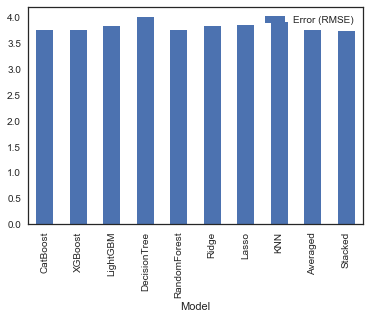

In [68]:
# Model definition
train_y = target

# Same lgbm and xgb models as before
lgbm_model = LGBMRegressor(
                objective="regression", metric="rmse", 
                max_depth=7, min_child_samples=20, 
                reg_alpha= 1, reg_lambda=1,
                num_leaves=64, learning_rate=0.001, 
                subsample=0.8, colsample_bytree=0.8, 
                verbosity=-1
)

xgb_model = XGBRegressor(
                eta=0.001, max_depth=7, 
                subsample=0.8, colsample_bytree=0.8, 
                objective='reg:linear', eval_metric='rmse', 
                silent=True
)


# Test catboost, random forest, decision tree, knn, ridge and lasso models individual performance, for averaged and stacked model
catboost_model = CatBoostRegressor(iterations=150)
rf_model = RandomForestRegressor(n_estimators=25, min_samples_leaf=25, min_samples_split=25)
tree_model = DecisionTreeRegressor(min_samples_leaf=25, min_samples_split=25)
knn_model = KNeighborsRegressor(n_neighbors=25, weights='distance')
ridge_model = Ridge(alpha=75.0)
lasso_model = Lasso(alpha=0.75)


# Average regressor
class AveragingRegressor(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, regressors):
        self.regressors = regressors
        self.predictions = None

    def fit(self, X, y):
        for regr in self.regressors:
            regr.fit(X, y)
        return self

    def predict(self, X):
        self.predictions = np.column_stack([regr.predict(X) for regr in self.regressors])
        return np.mean(self.predictions, axis=1)
    
    
averaged_model = AveragingRegressor([catboost_model, xgb_model, rf_model, lgbm_model])


stacked_model = StackingCVRegressor(
    regressors=[catboost_model, xgb_model, rf_model, lgbm_model],
    meta_regressor=Ridge()
)


# Test performance
def rmse_fun(predicted, actual):
    return np.sqrt(np.mean(np.square(predicted - actual)))

rmse = make_scorer(rmse_fun, greater_is_better=False)

models = [
     ('CatBoost', catboost_model),
     ('XGBoost', xgb_model),
     ('LightGBM', lgbm_model),
     ('DecisionTree', tree_model),
     ('RandomForest', rf_model),
     ('Ridge', ridge_model),
     ('Lasso', lasso_model),
     ('KNN', knn_model),
     ('Averaged', averaged_model),
     ('Stacked', stacked_model),
]


scores = [
    -1.0 * cross_val_score(model, train.values, train_y.values, scoring=rmse).mean()
    for _,model in models
]

In [ ]:
dataz = pd.DataFrame({ 'Model': [name for name, _ in models], 'Error (RMSE)': scores })
dataz.plot(x='Model', kind='bar')
plt.savefig('stacked_scores.png')

<a id='section28'></a>
## Results

In [71]:
dataz

,Error (RMSE),Model
0,3.762745,CatBoost
1,3.757660,XGBoost
2,3.835366,LightGBM
3,4.006086,DecisionTree
4,3.760558,RandomForest
5,3.830126,Ridge
6,3.844234,Lasso
7,3.908195,KNN
8,3.754827,Averaged
9,3.741480,Stacked


<a id='section29'></a>
## Predictions

In [91]:
# Stacked model predictions (best score)
stacked_model.fit(train.values, target.values)

cols = ['recent_sales_A_mean','recent_sales_B_mean', 'recent_sales_C_mean','recent_sales_D_mean', 
       'recent_sales_E_mean', 'recent_purchases_A_mean', 'recent_purchases_B_mean', 'recent_purchases_C_mean', 
       'recent_purchases_D_mean', 'recent_purchases_E_mean', 'category_4_mean',
       'purchase_amount_std', 'installments_std']

for col in cols:
    test[col].fillna((test[col].value_counts().index[0]), inplace=True)
    
predictions_stacked = stacked_model.predict(test.values)

0:	learn: 3.8282561	total: 30.4ms	remaining: 4.53s
1:	learn: 3.8241488	total: 56.6ms	remaining: 4.19s
2:	learn: 3.8193931	total: 82.6ms	remaining: 4.05s
3:	learn: 3.8149984	total: 108ms	remaining: 3.94s
4:	learn: 3.8107725	total: 133ms	remaining: 3.85s
5:	learn: 3.8068006	total: 158ms	remaining: 3.79s
6:	learn: 3.8030796	total: 184ms	remaining: 3.76s
7:	learn: 3.7995036	total: 209ms	remaining: 3.7s
8:	learn: 3.7966047	total: 232ms	remaining: 3.64s
9:	learn: 3.7935280	total: 263ms	remaining: 3.68s
10:	learn: 3.7911229	total: 291ms	remaining: 3.68s
11:	learn: 3.7884602	total: 328ms	remaining: 3.77s
12:	learn: 3.7857308	total: 357ms	remaining: 3.76s
13:	learn: 3.7832959	total: 386ms	remaining: 3.75s
14:	learn: 3.7806047	total: 411ms	remaining: 3.7s
15:	learn: 3.7783840	total: 433ms	remaining: 3.63s
16:	learn: 3.7758608	total: 458ms	remaining: 3.58s
17:	learn: 3.7739234	total: 490ms	remaining: 3.59s
18:	learn: 3.7719882	total: 520ms	remaining: 3.58s
19:	learn: 3.7701496	total: 550ms	remain

KeyboardInterrupt: 

<a id='section30'></a>
# Submission

In [90]:
# LightGBM/Xgboost
sub_df = pd.read_csv('../input/sample_submission.csv')
sub_df["target"] = 0.5 * predictions_lgb + 0.5 * predictions_xgb
sub_df.to_csv("submission.csv", index=False)

# Stacked
'''
sub_df = pd.read_csv('data/sample_submission.csv')
sub_df["target"] = predictions_stacked
sub_df.to_csv("submission.csv", index=False)
'''

Both scored almost equally on the test set, I picked lightgbm/xgboost for submission (about 0.001 less RMSE).

---
<a id='section31'></a>
# References
Special thanks to the following references:
- https://www.kaggle.com/mjbahmani/a-data-science-framework-for-elo (@mjbahmani)
- https://www.kaggle.com/youhanlee/hello-elo-ensemble-will-help-you (@youhanlee)
- https://www.kaggle.com/peterhurford/you-re-going-to-want-more-categories-lb-3-737 (@peterhurford)
- https://www.kaggle.com/eikedehling/comparing-models-xgb-lgb-rf-and-stacking (@eikedehling)